In [2]:
#Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import zipfile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

datasetzipfile = "datasets.zip"

# Check if the zip file exists
if os.path.exists(datasetzipfile):
    # Open the zip file in read mode
    with zipfile.ZipFile(datasetzipfile, 'r') as zip_ref:
        # Iterate through each file in the zip archive
        for file_info in zip_ref.infolist():
            # Check if the file already exists in the current directory
            if not os.path.exists(file_info.filename):
                zip_ref.extract(file_info)
else:
    print(f"{datasetzipfile} does not exist.")

train_path_dog = "datasets/train/dog"
train_path_cat = "datasets/train/cat"
valid_path_dog = "datasets/val/dog"
valid_path_cat = "datasets/val/cat"

test_path = "datasets/test"

#Count the Data Provided
def count_files_in_directory(path):
    try:
        # List all entries in the specified directory
        all_entries = os.listdir(path)
        
        # Count only the files (exclude directories)
        total_files = sum(1 for entry in all_entries if os.path.isfile(os.path.join(path, entry)))
        
        return total_files
    except Exception as e:
        return str(e)

# Specify the directory path
print("Total number of dog images in training data :", count_files_in_directory(train_path_dog))
print("Total number of cat images in training data :", count_files_in_directory(train_path_cat))
print()
print("Total number of dog images in validation data :", count_files_in_directory(valid_path_dog))
print("Total number of cat images in validation data :", count_files_in_directory(valid_path_cat))
print()
print("Total number of unknown images in test data :", count_files_in_directory(test_path))

Total number of dog images in training data : 10000
Total number of cat images in training data : 10000

Total number of dog images in validation data : 2500
Total number of cat images in validation data : 2500

Total number of unknown images in test data : 500


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Data generators are created.
Early stopping and learning rate reduction callbacks are set.

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model Summary
--------------
CNN Model: MobileNetV3Small


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,612,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,552,049 (17.36 MB)

 Trainable params: 3,612,929 (13.78 MB)

 Non-trainable params: 939,120 (3.58 MB)

None


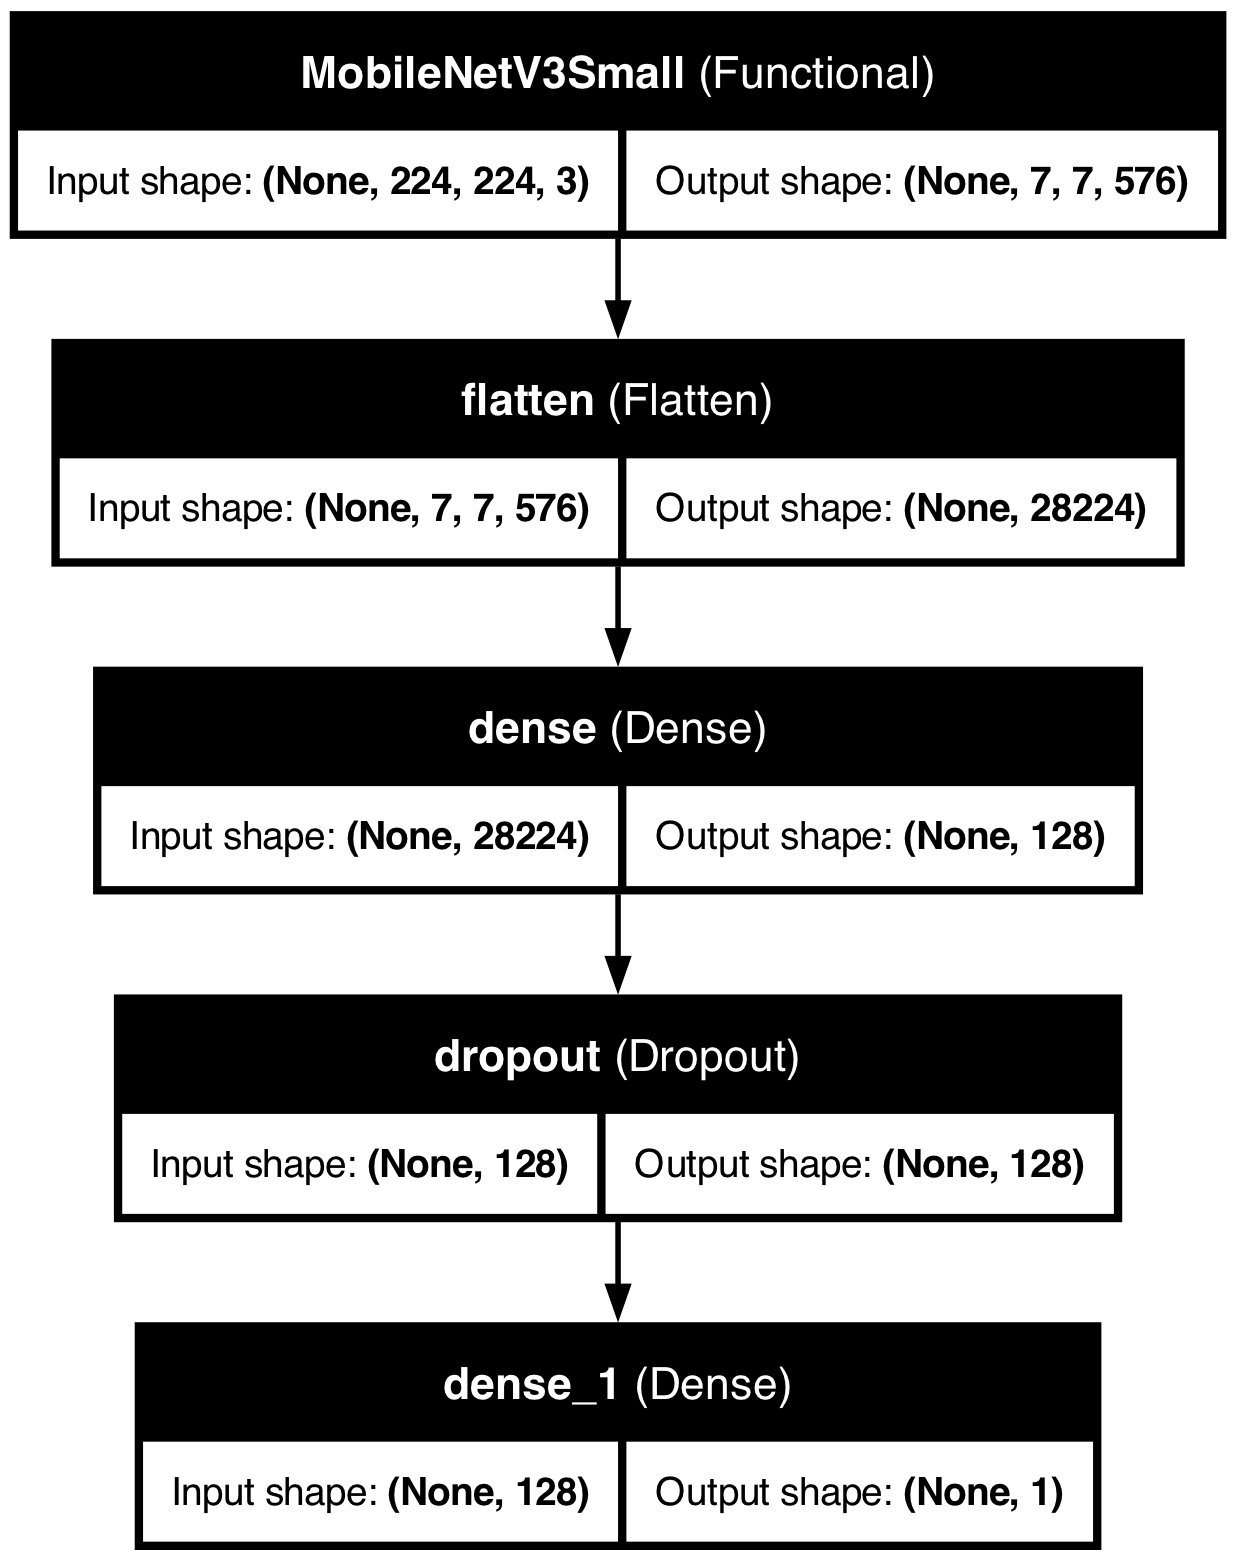

In [3]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

# Paths to training and validation directories
train_path = "datasets/train"
valid_path = "datasets/val"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for loading images from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Function to create the model
def create_model():
    """Build and compile the MobileNetV3Small model."""
    # Load MobileNetV3Large with ImageNet weights
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("Model Summary")
    print("--------------")
    print("CNN Model: MobileNetV3Small")
    print(model.summary())
    return model

# Callbacks for learning rate reduction and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

print()
print("Data generators are created.")
print("Early stopping and learning rate reduction callbacks are set.")
print()

# Function to build your model
model = create_model()  

# Save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
Image.open('model_architecture.png')

In [4]:
n_runs = 1
val_acc_results = []
val_loss_results = []

for run in range(n_runs):
    
    # Train the model
    history = model.fit(train_generator, 
                        validation_data=valid_generator,
                        epochs=25,
                        callbacks=[early_stop, reduce_lr])
    
    # Evaluate and store the validation accuracy
    val_loss, val_acc = model.evaluate(valid_generator)
    val_acc_results.append(val_acc)
    val_loss_results.append(val_loss)

    print("Run " + run + " Results:")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print()

/Users/mkabilan/Desktop/Mini-Proj_IE4483.nosync/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 413ms/step - accuracy: 0.5025 - loss: 0.8334 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 440ms/step - accuracy: 0.4979 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/25
 45/625 ━━━━━━━━━━━━━━━━━━━━ 3:44 387ms/step - accuracy: 0.4717 - loss: 0.6932

KeyboardInterrupt: 

In [ ]:
# Calculate and print average results
average_val_acc = np.mean(val_acc_results)
average_val_loss = np.mean(val_loss_results)

print("Average Results:")
print(f"Average Validation Accuracy: {average_val_acc:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")

In [ ]:
# Initialize an empty list to hold the results
results = []

# Loop through each file in the test directory
for img_file in os.listdir(test_path):
    # Load and preprocess the image
    img_path = os.path.join(test_path, img_file)
    img = image.load_img(img_path, target_size=(224, 224))  # Size should match input size of the model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale to match training preprocessing

    # Make a prediction
    prediction = model.predict(img_array)
    # If prediction >= 0.5, it's a dog (1); otherwise, it's a cat (0)
    prediction_label = 1 if prediction >= 0.5 else 0
    
    # Append the filename and prediction to the results list
    results.append([os.path.splitext(img_file)[0], prediction_label])

# Create a DataFrame for the results
df = pd.DataFrame(results, columns=['id', 'label'])

# Save the results to a CSV file
df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")